# Support Vector Machines #
**Support Vector Machines** (SVM) are a set of supervised machine learning algorithms used for regression, classification and outliers detection [[1]](https://scikit-learn.org/stable/modules/svm.html). SVM is widely popular because it works with small and complex data and produces high accuracy model with less significant power. The objective of the SVM is to find hyperplane in N dimenstional space, where N is the number of features that distinctly divides data to different classes [[2]](https://towardsdatascience.com/support-vector-machine-introduction-to-machine-learning-algorithms-934a444fca47). 

# Motivation #
When I was doing a Senior Project in my Bachelors degree, our team had a project which was about measuring and comparing Model Tree, MLP, and SVM in terms of interpretability and accuracy. We used a special interpretability metric for defining complexity of ml methods and were using different datasets. As a result we get that the Model tree is more interpretable than MLP and SVM, but SVM has good accuracy for complex datasets. So there existed some kind of tradeoff between interpretability and accuracy. I was closely studying how Model Tree and MLP works and had only a general view on how SVM operates. That is why I have chosen SVM, to understand how it works and what its difference from other ML methods.

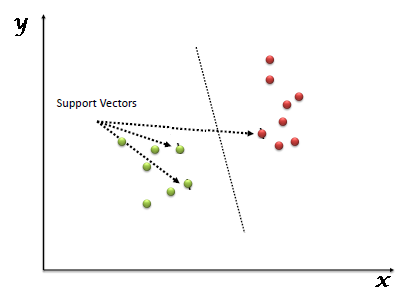


> Figure:1. data points divided by SVM hyperplane

**Support vectors** data points that lie closest to the decision surface. They fully specify decision function. 

**How it choses optimal hyperplane?**



1.   Thumb rule: find hyperplanes that segregates two classes better.
2.   Amongst those choose which has the maximum distance, **margin** from nearest data points

**Assumption** of the SVM: hyperplane which seperates the points and also far away from training data as it can be, will generize best unseen data. 



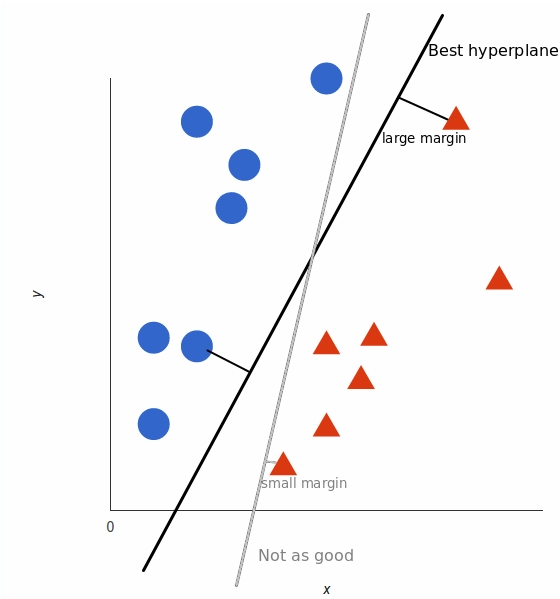

Any **linear hyperplane** can be defined by formula w^T x + b = 0, where x - is the data point that we want to classify, w - is the weight vector to minimize, b - is the constant that calculated from training data. Linear kernel is faster than others and has fewer parameters to optimize 

To find an optimal decision line first we need to find minimum margin across all point. After find (w, b) pair that maximizes the minumum margin. Thus, we get SVM objective function below:

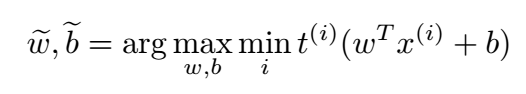

It's difficult to solve problem which involves a minimization and then maximization. So, let's try to convert it to a constrained optimization problem.
The problem of finding best hyperplane is an **optimization problem** and can be solved by optimization techniques like Lagrange multipliers. The method of Lagrange multipliers is a simple and elegant method of finding the local minima or local maxima of a function subject to equality or inequality constraints [[3]](https://machinelearningmastery.com/a-gentle-introduction-to-method-of-lagrange-multipliers/). 

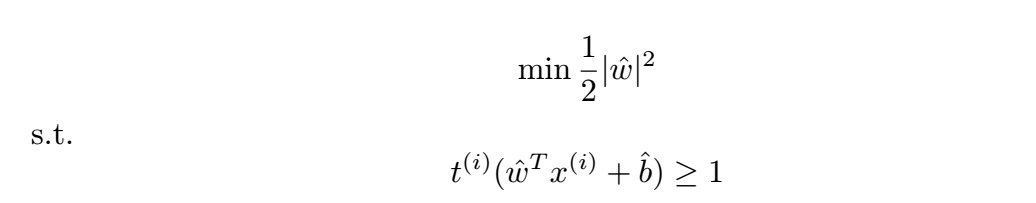

Constrained optimization problem can be solved by Lagrange multipliers technique. The idea used in Lagrange multiplier is that the gradient of the objective function f, lines up either in parallel or anti-parallel direction to the gradient of the constraint g, at an optimal point. In such case, one the gradients should be some multiple of another [[4]](https://towardsdatascience.com/understanding-support-vector-machine-part-1-lagrange-multipliers-5c24a52ffc5e).

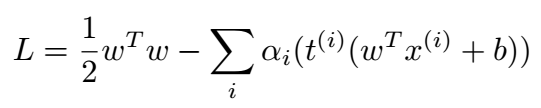

Then by taking derivative of the function with respect to w and b, we get formula for optimal w.

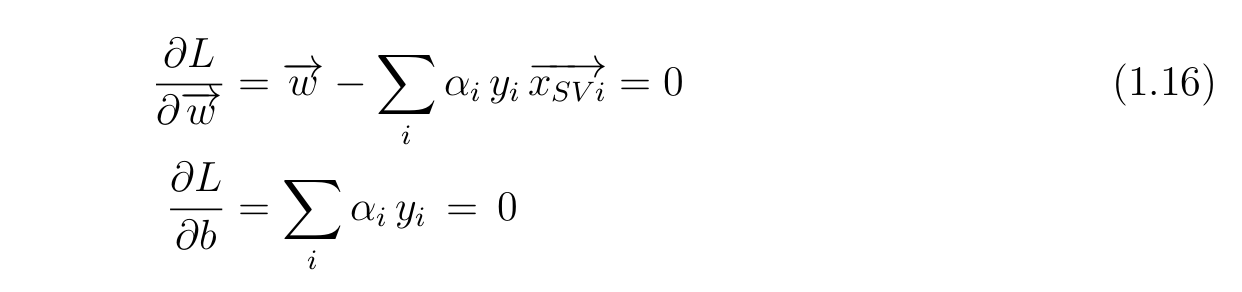

The result above is very important because we figured out that the normal vector (w) are linear combination of the support vectors. Now we can get rid of w and b and replace them by Lagrange multipliers. So we get:

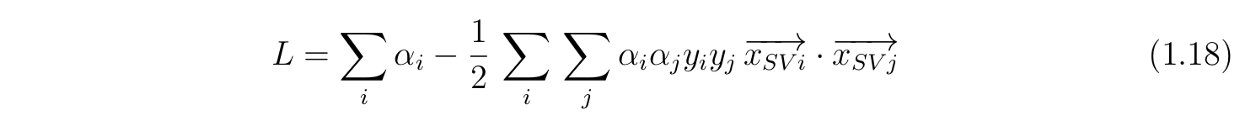

Finally, we have find out that maximization depends on the dot product of pairs of support vectors.

**Non-linear seperation problem**

As can be seen in the picture below there could be classification tasks where data can not be classified by line.

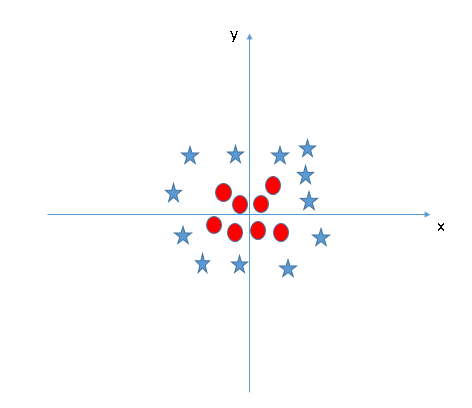
> Figure 2. Non-linear separable task.

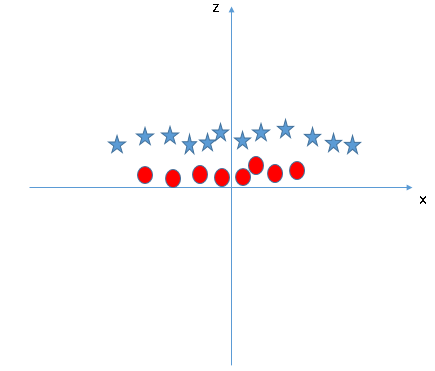

> Figure 3. Adding new feature to make data linearly separable

SVM solves this problem by introducing additional feature. For instance, $z= x^2 + y^2 $. 

Points to consider:


*   all values of z are greater than 0 because it's equal to sum of x and y squares.
*   in the first figure it can be noticed that red points are closer to origin so their z value will be smaller, and blue points are further, thus they have higher z value. 

SVM uses technique called **kernel trick** which converts low dimensional input to higher dimensional space 





1.   **Polynomial kernel**. More generalized form of the linear kernel. 
 
 Formula: $f(X1, X2) = (a + X1^T * X2) ^ d$, where d is the degree of polynomial space. 

2.   **Radial Basis Function Kernel**. Popular kernel function used in classification tasks, it can map input space to infinite dimensional space.

 Formula: $f(X1, X2) = exp(-gamma * ||X1 - X2||^2)$, where gamma is value between 0 and 1.



**Tuning parameters of SVM**



1.   **C**. It controls the trade off between smooth decision boundary and classifying training points correctly [[5]](https://towardsdatascience.com/https-medium-com-pupalerushikesh-svm-f4b42800e989). As it gets larger, more and more training data will be classified correctly.
2.   **gamma**. Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’. High value of gamma will cause that only close data points will impact to decision boundary. 



## Import libraries ##

In [ ]:
import numpy as np
import cvxopt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

## Class SVM ##

Next, to solve Lagrangian multiplication we need to use CVXOPT library and express equation in terms of matrices not summations. So we need to convert our multiplication to


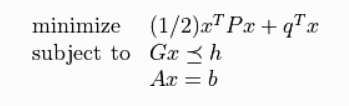

So, as a result we get following equations of matrices which expected by CVXOPT library.

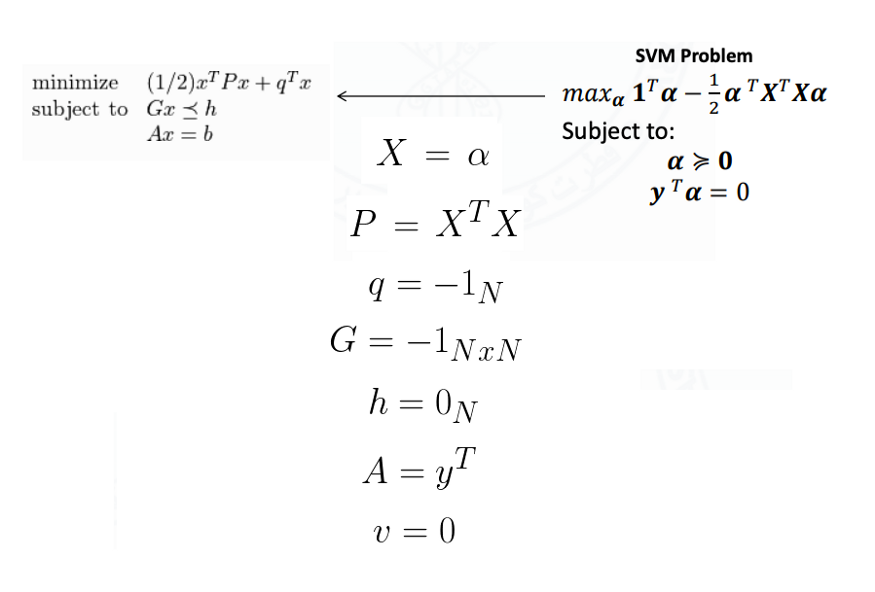

In [ ]:
class SVM:
  def fit(self, X, y):
          n_samples, n_features = X.shape
          # P = X^T X
          K = np.zeros((n_samples, n_samples))
          for i in range(n_samples):
              for j in range(n_samples):
                  K[i,j] = np.dot(X[i], X[j])
          P = cvxopt.matrix(np.outer(y, y) * K)
          # q = -1 (1xN)
          q = cvxopt.matrix(np.ones(n_samples) * -1)
          # A = y^T 
          A = cvxopt.matrix(y, (1, n_samples))
          # b = 0 
          b = cvxopt.matrix(0.0)
          # -1 (NxN)
          G = cvxopt.matrix(np.diag(np.ones(n_samples) * -1))
          # 0 (1xN)
          h = cvxopt.matrix(np.zeros(n_samples))
          solution = cvxopt.solvers.qp(P, q, G, h, A, b)
          # Lagrange multipliers
          a = np.ravel(solution['x'])
          # Lagrange have non zero lagrange multipliers
          sv = a > 1e-5
          ind = np.arange(len(a))[sv]
          self.a = a[sv]
          self.sv = X[sv]
          self.sv_y = y[sv]
          # Intercept
          self.b = 0
          for n in range(len(self.a)):
            self.b += self.sv_y[n]
            self.b -= np.sum(self.a * self.sv_y * K[ind[n], sv])
          self.b /= len(self.a)
          # Weights
          self.w = np.zeros(n_features)
          for n in range(len(self.a)):
            self.w += self.a[n] * self.sv_y[n] * self.sv[n]
                
  def project(self, X):
    return np.dot(X, self.w) + self.b
        
        
  def predict(self, X):
    return np.sign(self.project(X))

cvxopt expects the data to be in a specific format which is why we take an intermediate step.

In [ ]:
X, y = make_blobs(n_samples=250, centers=2,
                  random_state=0, cluster_std=0.60)
y[y == 0] = -1
tmp = np.ones(len(X))
y = tmp * y

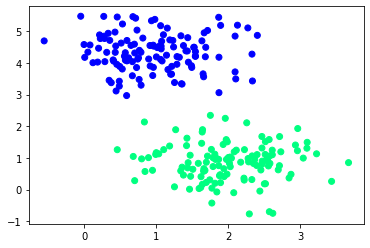

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='winter')


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [ ]:
svm = SVM()
svm.fit(X_train, y_train)

     pcost       dcost       gap    pres   dres
 0: -1.8226e+01 -3.4458e+01  6e+02  2e+01  2e+00
 1: -2.5252e+01 -1.8773e+01  2e+02  9e+00  7e-01
 2: -5.3459e+01 -3.2711e+01  2e+02  7e+00  6e-01
 3: -7.8360e+01 -2.6482e+01  1e+02  4e+00  3e-01
 4: -5.6818e+00 -5.1750e+00  1e+01  2e-01  1e-02
 5: -3.6906e+00 -4.1082e+00  4e-01  4e-16  9e-15
 6: -4.0061e+00 -4.0104e+00  4e-03  1e-15  6e-15
 7: -4.0094e+00 -4.0094e+00  4e-05  1e-15  4e-15
 8: -4.0094e+00 -4.0094e+00  4e-07  2e-15  7e-15
Optimal solution found.


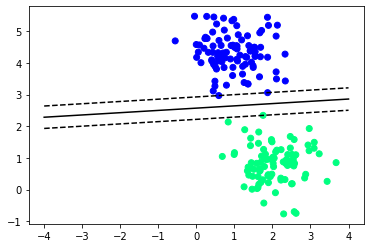

In [ ]:
def f(x, w, b, c=0):
    return (-w[0] * x - b + c) / w[1]
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter')
# w.x + b = 0
a0 = -4; a1 = f(a0, svm.w, svm.b)
b0 = 4; b1 = f(b0, svm.w, svm.b)
plt.plot([a0,b0], [a1,b1], 'k')
# w.x + b = 1
a0 = -4; a1 = f(a0, svm.w, svm.b, 1)
b0 = 4; b1 = f(b0, svm.w, svm.b, 1)
plt.plot([a0,b0], [a1,b1], 'k--')
# w.x + b = -1
a0 = -4; a1 = f(a0, svm.w, svm.b, -1)
b0 = 4; b1 = f(b0, svm.w, svm.b, -1)
plt.plot([a0,b0], [a1,b1], 'k--')

In [ ]:
y_pred = svm.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[29,  0],
       [ 0, 34]])

In [ ]:
svc = LinearSVC()
svc.fit(X_train, y_train)

LinearSVC()

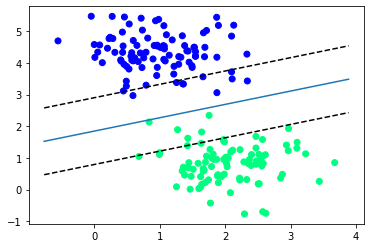

In [ ]:
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='winter');
ax = plt.gca()
xlim = ax.get_xlim()
w = svc.coef_[0]
a = -w[0] / w[1]
xx = np.linspace(xlim[0], xlim[1])
yy = a * xx - svc.intercept_[0] / w[1]
plt.plot(xx, yy)
yy = a * xx - (svc.intercept_[0] - 1) / w[1]
plt.plot(xx, yy, 'k--')
yy = a * xx - (svc.intercept_[0] + 1) / w[1]
plt.plot(xx, yy, 'k--')

In [ ]:
y_pred = svc.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[29,  0],
       [ 0, 34]])